# Learning an Image Classification Model from Scratch

* Based on [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python-second-edition?gclid=CjwKCAjw9aiIBhA1EiwAJ_GTSlKgxc4qopKHPsFWryOoTz7fvhvhzYSjEsgQ-bG1R51QSGppISywpBoClcIQAvD_BwE) by Francois Chollett



---



---



## Product Idea!

You have an amazing app idea: 

*Scan Facebook and Instagram images and based on what category of clothing a person is wearing, recommend **complementary** products (e.g., matching handbags, ties, jackets) to that person*



## Potential Approach


Here's one approach:

1.   First build a DL model that can determine what *category* of clothing the person is wearing => a **category detection** model

2.   Then build another DL model that can detect the *color* of the clothing => a **color detection** model

Once we know the type and color of the clothing item, we can look up recommendations for complementary products from our fashion database.

(Aside: real-world industrial-strength DL systems typically have **multiple** NNs assembled in a pipeline to get the job done)


**OK, where should we start?**



## Training Data

The starting point for building DL models is almost always the same ==> **GET RELEVANT TRAINING DATA**!


So we do a little Googling ...

<br>

... and discover Fashion-MNIST! 


### The Fashion MNIST dataset



The [fashion_mnist](https://github.com/zalandoresearch/fashion-mnist) dataset consists of 70,000 images of clothing items across 10 categories.

![Fashion MNIST](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)


The images are black-and-white so we can't use this dataset for the **color detection** model above but since they are nicely categorized, we can definitely use it for building the **category detection** model.

<br>

Luckily for us, this dataset is available in a convenient format through Keras, so we will load it and take a look.

But first, let's get some technical preliminaries out of the way.



---



---



---


We will first import the following packages and set the seed for the random number generator.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the 
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

With the technical preliminaries out of the way, let's load the dataset and take a look.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


There are 60,000 images in the training set, each of which is a 28x28 matrix. 

In [ ]:
print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


The remaining 10,000 images are in the test set.

<br>

OK, let's look at the first 10 rows of the dependent variable $y$.





In [ ]:
y_train[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

**What do these numbers mean?**

According to the [Fashion MNIST Github site](https://github.com/zalandoresearch/fashion-mnist#labels), this is what each number 0-9 corresponds to:

| Label  | Description  |
|---|---|
|  0 | T-shirt/top  |
|  1 |  Trouser |
|  2 |   Pullover |
|  3 |  Dress |
|  4 |  Coat |
|  5 |  Sandal |
|  6 |   Shirt |
|  7 |  Sneaker |
|  8 |   Bag |
|  9 |  Ankle boot |

Let's create a little Python list so that we can go from numbers to descriptions easily. 

In [ ]:
labels = ["T-shirt/top", 
          "Trouser", 
          "Pullover",
          "Dress", 
          "Coat",
          "Sandal", 
          "Shirt", 
          "Sneaker", 
          "Bag", 
          "Ankle boot"]  



Given a number, the description is now a simple look-up. Let's see what the very first training example is about.

In [ ]:
labels[y_train[0]]

'Ankle boot'

The very first image is an "Ankle boot"! 

Let's take a look at the **raw data** for the image.

In [ ]:
print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23


Let's look at the first 25 images using the handy `plt.imshow()` command



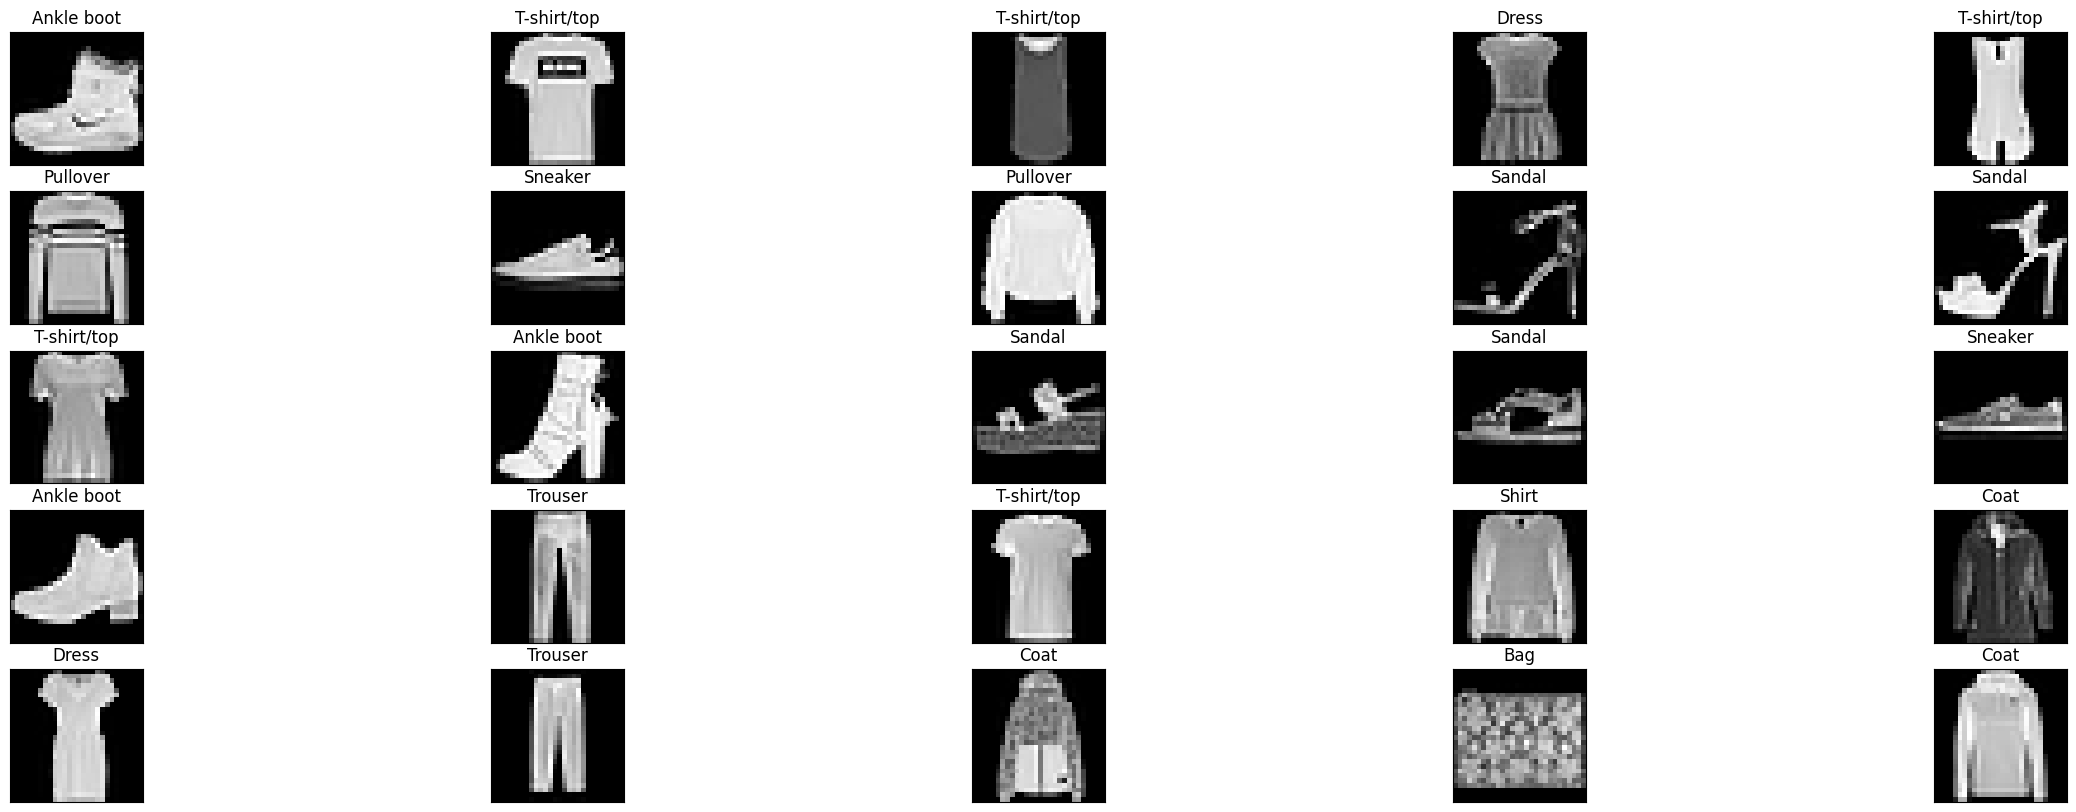

In [ ]:
fig = plt.figure(figsize=(30, 10))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.set_title(f"{labels[y_train[i]]}")
    ax.imshow(x_train[i], cmap="gray")

The images are a bit small but they will do for now.

## A NN Model - First Attempt

Our first NN will be a simple one with a single hidden layer.

### Data Prep

**Tip**: NNs learn best when each independent variable is in a small range. So, standardize them by either 
- subtracting the mean and dividing by the standard deviation or 
- if they are in a guaranteed range, just divide by the max value.

The inputs here range from 0 to 255. Let's normalize to the 0-1 range by dividing everything by 255.

In [ ]:
x_train = x_train/ 255.0
x_test = x_test/ 255.0

### Define Model in Keras

Recap of the NN we designed in class:

* The input will be 28 x 28 matrices of numbers. These will have to be *flattened* into a loooong vector and then fed to the next layer. 
* We will use just a single hidden layer. 
* Since this is a *multi-class classification problem* (e.g., we need to predict one of 10 clothing categories), the output layer has to produce a 10-element vector of probabilities that sum up to 1.0  => we will use the *softmax* layer.

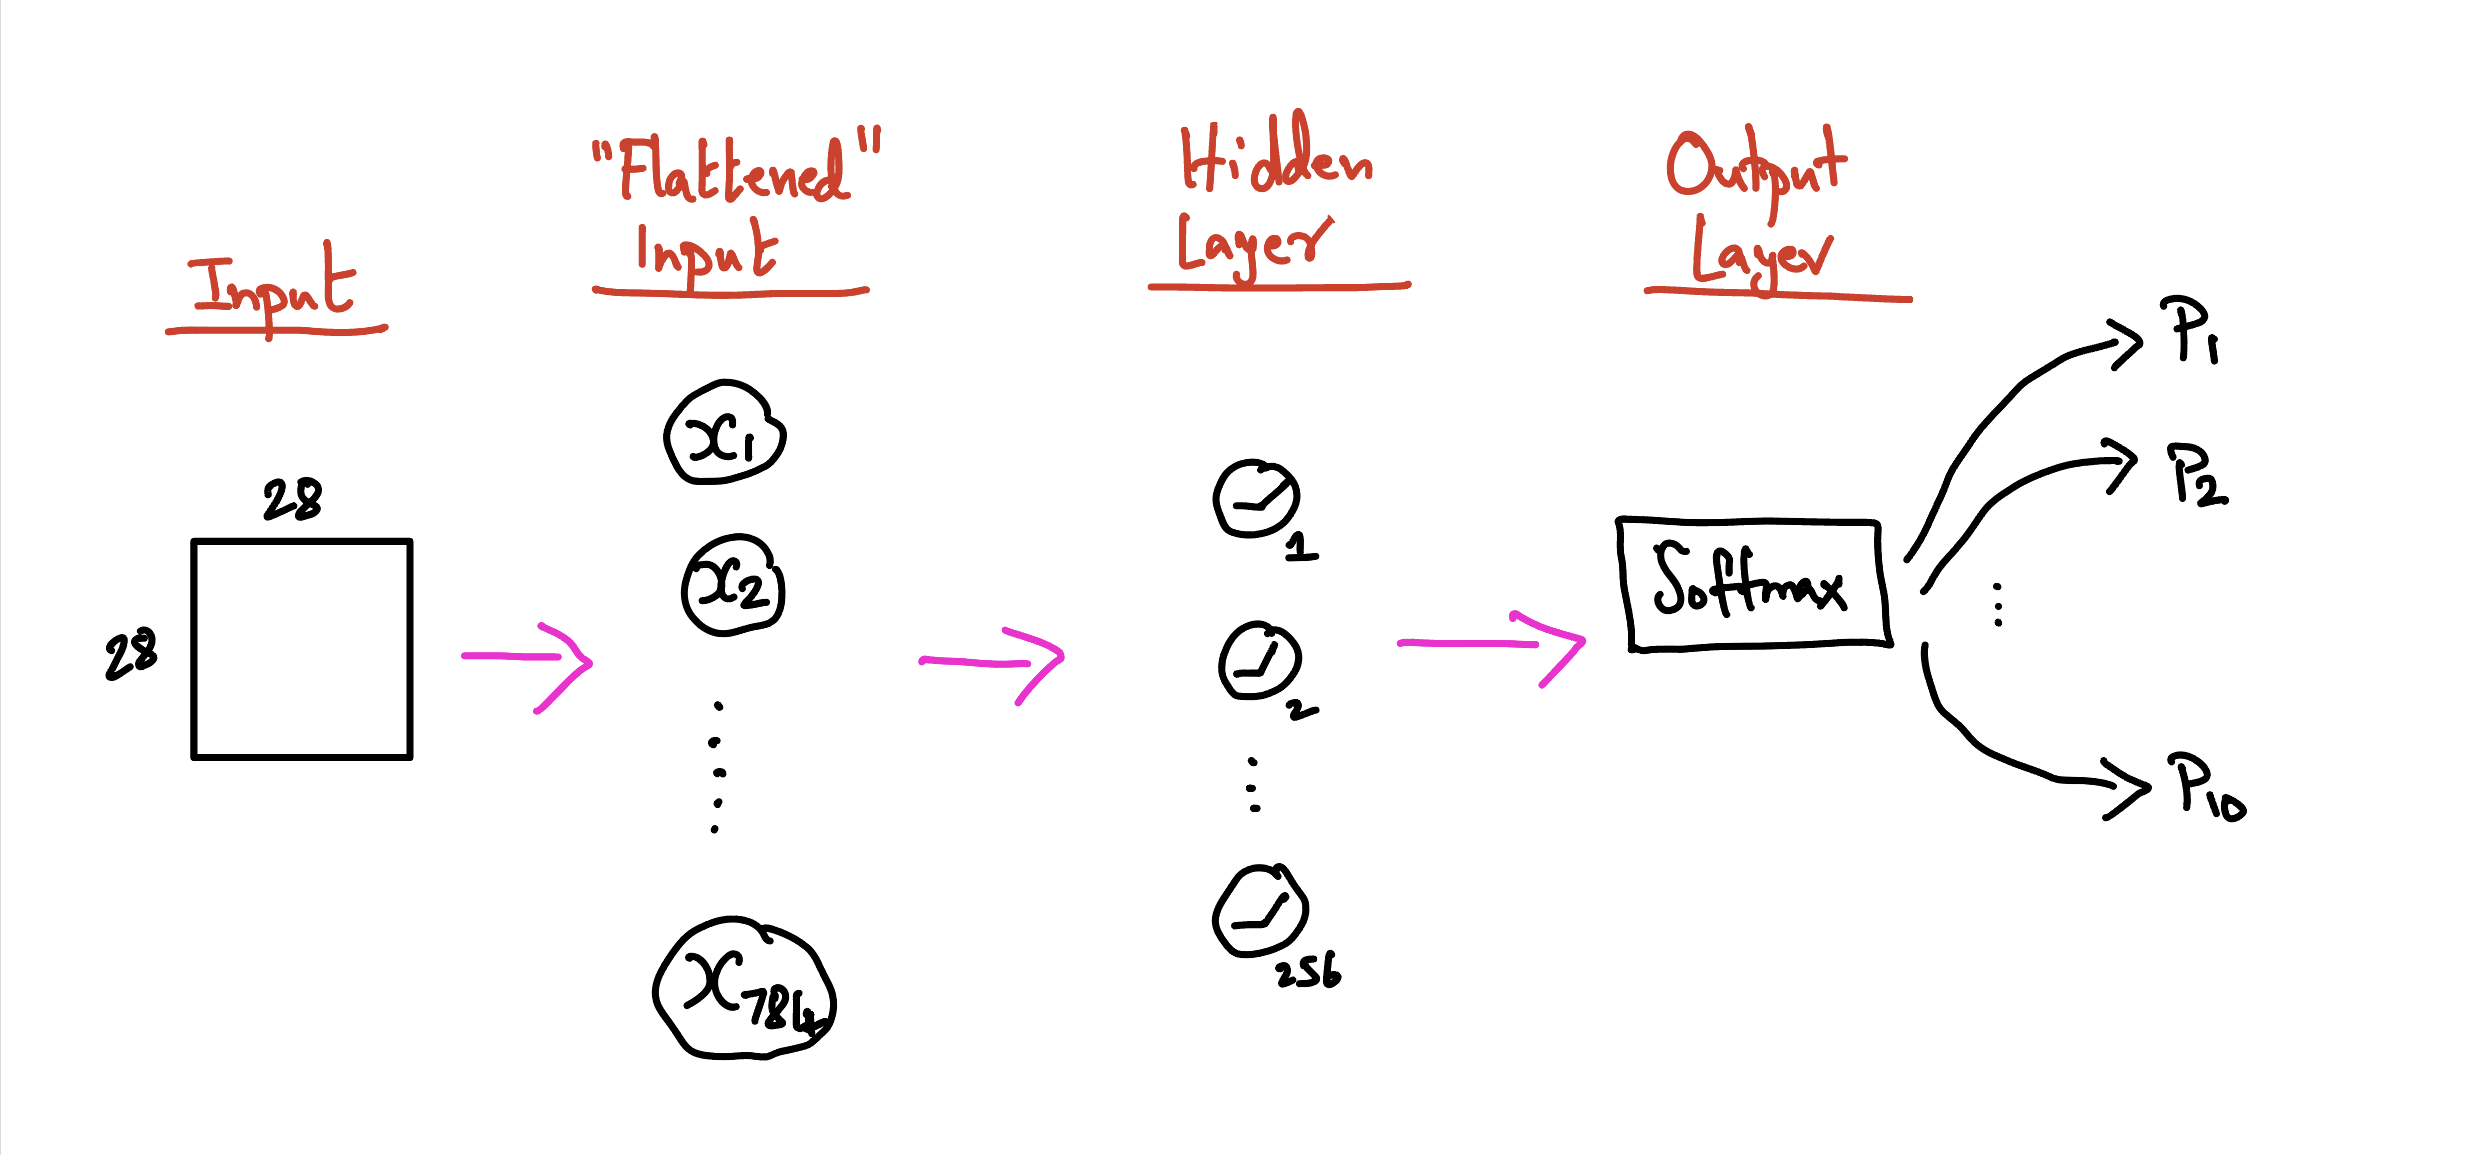

Let's "translate" this to Keras.

In [ ]:
# define the input layer
input = keras.Input(shape=(28,28))

# convert the 28 x 28 matrix of numbers into a long vector
h = keras.layers.Flatten()(input)

# feed the long vector to the hidden layer
h = keras.layers.Dense(256, activation="relu", name="Hidden")(h)

# feed the output of the hidden layer to the output layer
output = keras.layers.Dense(10, activation="softmax", name="Output")(h)

# tell Keras that this (input,output) pair is your model
model = keras.Model(input, output)

The `model.summary()` command is a good way to get a quick overview of what you have defined.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Hidden (Dense)              (None, 256)               200960    
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


Let's hand-calculate the number of parameters to verify.

In [ ]:
(784 * 256 + 256) + (256 * 10 + 10) 

203530

We can "visualize" the network graphically as well using Keras' `plot_model` function.

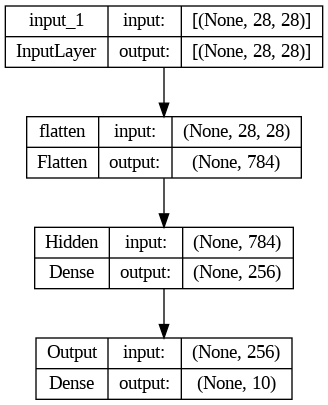

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

### Set Optimization Parameters

Now that the model is defined, we need to tell Keras three things:

*   What **loss function** to use 
*   Which **optimizer** to use - we will again use **Adam** which is an excellent set-and-forget choice 
*   What **metrics** you want Keras to report out - in classification problems like this one, Accuracy is usually the metric you want to see.


Since our output variable is categorical with 10 levels, we will select the `sparse_categorical_crossentropy` loss function.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

### Train the Model!

* The *batch size*: 32 or 64 are commonly used
* The number of *epochs* i.e., how many passes through the training data: we will start with 20. 
* To check for overfitting, we will ask Keras to automatically use 20% of the training data points as a validation set

---

OK, let's train the model using the `model.fit` function!


In [ ]:
batch_size = 64
epochs = 20

history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_split=0.2)

Epoch 1/20
750/750 [==============================] - 8s 4ms/step - loss: 0.5162 - accuracy: 0.8185 - val_loss: 0.4106 - val_accuracy: 0.8572
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 0.3851 - accuracy: 0.8631 - val_loss: 0.3846 - val_accuracy: 0.8615
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 0.3431 - accuracy: 0.8752 - val_loss: 0.3407 - val_accuracy: 0.8767
Epoch 4/20
750/750 [==============================] - 2s 3ms/step - loss: 0.3161 - accuracy: 0.8852 - val_loss: 0.3405 - val_accuracy: 0.8758
Epoch 5/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2972 - accuracy: 0.8908 - val_loss: 0.3363 - val_accuracy: 0.8810
Epoch 6/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2791 - accuracy: 0.8969 - val_loss: 0.3213 - val_accuracy: 0.8815
Epoch 7/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2668 - accuracy: 0.9024 - val_loss: 0.3105 - val_accuracy: 0.8888
Epoch 

Let's plot the loss and accuracy curves to see if ***overfitting*** is going on and if **early stopping** may be needed.

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

We will use the code from the previous colab but put it in a couple of functions to minimize typing.

In [ ]:
def plot_loss_curves(history):
  plt.clf()
  history_dict = history.history
  loss_values = history_dict["loss"]
  val_loss_values = history_dict["val_loss"]
  epochs = range(1, len(loss_values) + 1)
  plt.plot(epochs, loss_values, "bo", label="Training loss")
  plt.plot(epochs, val_loss_values, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [ ]:
def plot_acc_curves(history):
  plt.clf()
  history_dict = history.history
  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, "bo", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

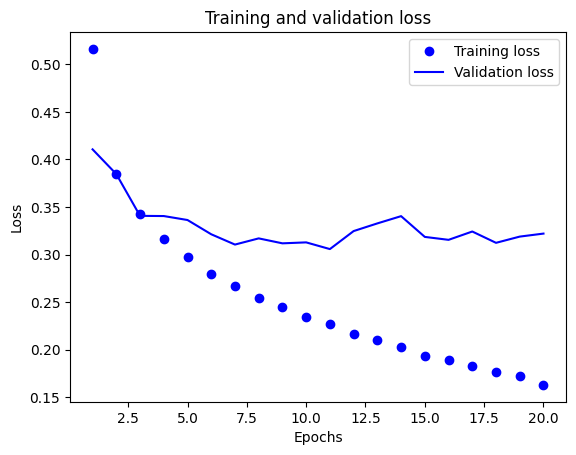

In [ ]:
plot_loss_curves(history)

Do you think there's overfitting?

If you think there's overfitting at epoch N, we could go back, re-initialize the model and just run it for  N epochs - that would be an example of **early stopping**.

Let's look at the accuracy curves as well.

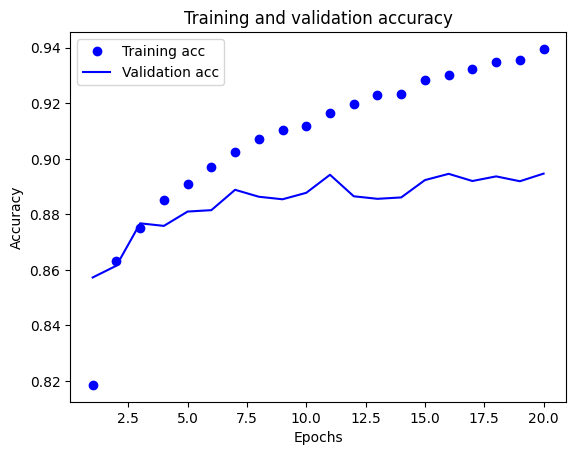

In [ ]:
plot_acc_curves(history)

What do you think? Are we overfitting?

### Evaluate the Model

Let's see **how well the model does on the test set**. 


In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3621 - accuracy: 0.8885


[0.3621083199977875, 0.8884999752044678]

89% accuracy on a 10-class classification problem.

**Is this impressive? What's a goood baseline to compare it to?**



### If we want to add a **second** hidden layer, how easy is it?

In [ ]:
# define the input layer
input = keras.Input(shape=(28,28))

# convert the 28 x 28 matrix of numbers into a long vector
h = keras.layers.Flatten()(input)

# feed the long vector to the first hidden layer
h = keras.layers.Dense(256, activation="relu", name="Hidden_1")(h)

# THIS IS THE ADDITIONAL LINE
# feed the output of the first hidden layer to the second hidden layer
h = keras.layers.Dense(256, activation="relu", name="Hidden_2")(h)

# feed the output of the second hidden layer to the output layer
output = keras.layers.Dense(10, activation="softmax", name="Output")(h)


# tell Keras that this (input,output) pair is your model
model = keras.Model(input, output)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 Hidden_1 (Dense)            (None, 256)               200960    
                                                                 
 Hidden_2 (Dense)            (None, 256)               65792     
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


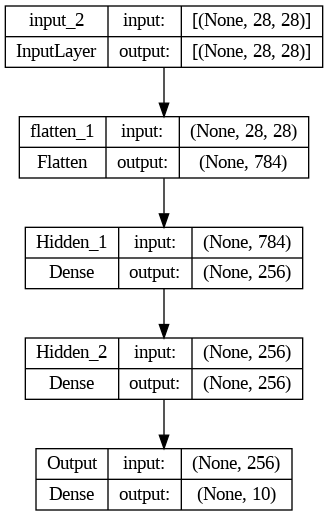

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

You are welcome to train the model above and see how well it does on the test set.

Use these commands (as we did above):


*   `model.compile`
*   `model.fit`
*   `model.evaluate`



